### Import libraries and read in file

In [194]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# models and stuff
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

In [195]:
# read in file and define some useful column groupings
# elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
elec_w_weather_path = '/Users/ian.myjer/repos/gafp/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [196]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','office','outside_plug','entertainment','utility_room','unmetered','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

## Features

In [197]:
def feature_creation(df):
    # starting features
    feature_cols = ['main_house_total','Temp (C)']
    
    # time-based features
    # only hour ever seemed to matter
#     df['dow'] = df.index.weekday
#     df['weekday'] = (df.index.weekday < 5)*1
#     df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
    df['hour'] = df.index.hour
    feature_cols.append('hour')

    # season dummies
    # pretty much never important
#     df['winter'] = (df.index.month<=3)*1
#     df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
#     df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
#     df['fall'] = (df.index.month>9)*1

#     main house power percentage change and diff
#     pretty much never important
    for interval in [1,3,5,9,15]:
        df['mht_pct_'+str(interval)] = df['main_house_total'].pct_change(interval).fillna(0).replace(np.inf,1000)
        df['mht_diff_'+str(interval)] = df['main_house_total'].diff(periods=interval).fillna(0)
        df['mht_pct_'+str(interval)+'_squared'] = df['mht_pct_'+str(interval)]**2
        df['mht_diff_'+str(interval)+'_squared'] = df['mht_diff_'+str(interval)]**2
        feature_cols.append('mht_pct_'+str(interval))
        feature_cols.append('mht_diff_'+str(interval))
        feature_cols.append('mht_pct_'+str(interval)+'_squared')
        feature_cols.append('mht_diff_'+str(interval)+'_squared')
    
#     ## help identifying "start" and "stop" points
#     df['diff_binary'] = np.where((df['mht_diff_1']>500)|(df['mht_diff_1']<500),1,0)
#     feature_cols.append('diff_binary')
    
    # exponential weighted mean
    for t in [15,45,90,150,300]:
        df['ewm_mean_'+str(t)] = df['main_house_total'].ewm(span=t).mean()
        feature_cols.append('ewm_mean_'+str(t))
    
#     # autocorrelation
#     for t in [30,60,1400,4320,10080]:
#         df['autocorr_'+str(t)] = df['main_house_total'].autocorr(lag=t)
#         feature_cols.append('autocorr_'+str(t))
        
    # rolling stats
    for time_val in [15,30,60,90]:
        df['rolling_sum_'+str(time_val)] = df['main_house_total'].rolling(time_val).sum().fillna(0)
        df['rolling_mean_'+str(time_val)] = df['main_house_total'].rolling(time_val).mean().fillna(0)
        df['rolling_max_'+str(time_val)]  = df['main_house_total'].rolling(time_val).max().fillna(0)
        df['rolling_min_'+str(time_val)]  = df['main_house_total'].rolling(time_val).min().fillna(0)
        df['rolling_median_'+str(time_val)]  = df['main_house_total'].rolling(time_val).median().fillna(0)
        df['rolling_skew_'+str(time_val)]  = df['main_house_total'].rolling(time_val).skew().fillna(0)
        df['rolling_kurtosis_'+str(time_val)]  = df['main_house_total'].rolling(time_val).kurt().fillna(0)
        df['rolling_corr_'+str(time_val)]  = df['main_house_total'].rolling(time_val).corr().fillna(0)
        df['rolling_cov_'+str(time_val)]  = df['main_house_total'].rolling(time_val).cov().fillna(0)
        feature_cols.append('rolling_sum_'+str(time_val))
        feature_cols.append('rolling_mean_'+str(time_val))
        feature_cols.append('rolling_max_'+str(time_val))
        feature_cols.append('rolling_min_'+str(time_val))
        feature_cols.append('rolling_median_'+str(time_val))
        feature_cols.append('rolling_cov_'+str(time_val))
#         feature_cols.append('rolling_skew_'+str(time_val))
#         feature_cols.append('rolling_kurtosis_'+str(time_val))
#         feature_cols.append('rolling_corr_'+str(time_val))

    return feature_cols

## Modelling Functions

In [198]:
def tts(X,y,percent=0.66):
    train_size = int(len(X) * percent)
    X_train, X_test = X[0:train_size], X[train_size:len(X)]
    y_train, y_test = y[0:train_size], y[train_size:len(X)]
    return X_train, X_test, y_train, y_test

In [199]:
def tts_small(X,y,first_split=0.33,second_split=0.66):
    train_size = int(len(X) * first_split)
    test_size = int(len(X) * second_split)
    X_train, X_test = X[0:train_size], X[train_size:test_size]
    y_train, y_test = y[0:train_size], y[train_size:test_size]
    return X_train, X_test, y_train, y_test

In [200]:
def model_chooser(model_type,X_train,X_test,y_train,n_estimators=10,max_features='auto'):
    if model_type == 'random_forest':
        model = RandomForestClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'logistic_regression':
        model = LogisticRegression()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'extra_trees':
        model = ExtraTreesClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    elif model_type == 'ada_boost':
        model = AdaBoostClassifier(random_state=42,n_estimators=n_estimators)
    elif model_type == 'gradient_boost':
        model = GradientBoostingClassifier(random_state=42,n_estimators=n_estimators,max_features=max_features)
    else:
        model = None

    # fit and predict on model
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1]
    
    return model, y_pred, y_pred_proba

In [201]:
def print_accuracies(lbl,y_test,y_pred,y_pred_proba):
    print(lbl)
    # Predict appliances are always OFF
    y_null = np.zeros(len(y_test))
    print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))

    # total accuracy
    print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
    print('Log Loss: {:0.4f}'.format(metrics.log_loss(y_test,y_pred_proba)))

    # binary accuracy
    print('Accuracy Score 1s: {:0.4f}'.format(metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1])))
    print('Accuracy Score 0s: {:0.4f}'.format(metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0])))
    
    # confusion matrix
    print(metrics.confusion_matrix(y_test,y_pred))

In [202]:
def save_accuracies(lbl,model_type,y_test,y_pred,y_pred_proba):
    dct = {}
    y_null = np.zeros(len(y_test))
    dct[model_type+'_null_accuracy'] = metrics.accuracy_score(y_test, y_null)
    dct[model_type+'_total_accuracy'] = metrics.accuracy_score(y_test, y_pred)
    dct[model_type+'_log_loss'] = metrics.log_loss(y_test,y_pred_proba)
    dct[model_type+'_accuracy_1'] = metrics.accuracy_score(y_test[y_test==1], y_pred[y_test==1])
    dct[model_type+'_accuracy_0'] = metrics.accuracy_score(y_test[y_test==0], y_pred[y_test==0])
    return dct                                  

## Find and map max appliance

In [203]:
df['max_power'] = df[power_cols].max(axis=1)
df['col_max_row'] = df[power_cols].idxmax(axis=1)
df['col_max_row_remapped'] = df['col_max_row'].map(dict(zip(power_cols,range(len(power_cols)+1))))

# check if it's right
dict(zip(power_cols,range(len(power_cols)+1)));

## Classify max appliance

In [204]:
feature_cols = feature_creation(df)
lbl = 'col_max_row_remapped'
model_type = 'random_forest'

X = df[feature_cols]
y = df[lbl]

X_train, X_test, y_train, y_test = tts(X,y)

model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train,n_estimators=100,max_features='auto')

In [205]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [206]:
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False)

,0,1
0,main_house_total,0.160138
31,rolling_min_15,0.048137
23,ewm_mean_15,0.047992
20,mht_diff_15,0.044658
16,mht_diff_9,0.041775
32,rolling_median_15,0.035187
19,mht_pct_15,0.035185
15,mht_pct_9,0.033784
30,rolling_max_15,0.030718
37,rolling_min_30,0.026644


In [207]:
mapping = dict(zip(power_cols,range(len(power_cols)+1)))
mapping

{'basement': 2,
 'dhw_heater': 13,
 'dining_room': 5,
 'dishwasher': 6,
 'dryer': 3,
 'entertainment': 16,
 'furnace_fan': 10,
 'garage': 11,
 'heat_pump': 12,
 'north_br': 0,
 'office': 14,
 'outside_plug': 15,
 'oven': 19,
 'refrigerator': 9,
 'security_system': 8,
 'south_br': 1,
 'unmetered': 18,
 'utility_room': 17,
 'washer': 4,
 'workbench': 7}

In [208]:
# total accuracy
most_common_val = y_test.value_counts(sort=True).head(1).index[0]
y_null = np.ones(len(y_test))*most_common_val
print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))
print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))
cm = pd.DataFrame(metrics.confusion_matrix(y_test,y_pred))
pd.concat([cm], keys=['Actual'])

Null Accuracy Score: 0.3801
Total Accuracy Score: 0.8025
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        12
          1       0.77      0.01      0.02      7156
          2       0.67      0.51      0.58     19684
          3       0.93      0.96      0.95      5109
          4       0.75      0.02      0.05      2507
          6       0.89      0.56      0.69      5788
          7       0.00      0.00      0.00         7
          8       0.00      0.00      0.00         1
          9       0.68      0.73      0.71     45071
         10       0.94      0.85      0.89    107894
         11       0.00      0.00      0.00        27
         12       0.93      0.96      0.95     23564
         14       0.00      0.00      0.00       197
         16       0.86      0.00      0.00      3252
         18       0.75      0.89      0.81    135801
         19       0.82      0.47      0.59      1196

avg / total       0.81      0.80      0.

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0   1      2     3   4     5   6   7      8      9   10     11  12  \
Actual 0    0   0      0     0   0     0   0   0      0      0   0      0   0   
       1    0  79      0     0   0     0   0   0   1187   2293   0      0   0   
       2    0   0  10042    26   0    54   0   0      9      0   0      1   0   
       3    0   0     11  4925   0     0   0   0      0      0   0      0   0   
       4    0   0     87    13  62    29   0   0    117     46   0      0   0   
       5    0   0    185     0   3  3246   0   0     65      0   0     50   0   
       6    0   0      0     0   0     0   0   0      0      0   0      0   0   
       7    0   0      0     0   0     0   0   0      0      1   0      0   0   
       8    0   9    106     3   1    25   0   0  33066    629   0     12   0   
       9    0  13      1     0   2     0   0   0   7252  91733   0      0   0   
       10   0   0      1     0   0     0   0   0      1     10   0      0   0   
       11   0   0      0    14   2     2   0   0      1      0   0  22685   0   
       12   0   0     10     0   0     1   0   0     37     42   0      0   0   
       13   0   0   1335     0   0     4   0   0     68      1   0      0   0   
       14   0   1   3235   137  13   287   0   0   6818   3294   0   1645   0   
       15   0   0      0   166   0     0   0   0      4      0   0     24   0   

           13      14   15  
Actual 0    0      12    0  
       1    0    3597    0  
       2    0    9552    0  
       3    0     171    2  
       4    0    2153    0  
       5    0    2239    0  
       6    0       7    0  
       7    0       0    0  
       8    0   11220    0  
       9    0    8890    3  
       10   0      15    0  
       11   0     802   58  
       12   0     107    0  
       13   6    1838    0  
       14   1  120309   61  
       15   0     443  559

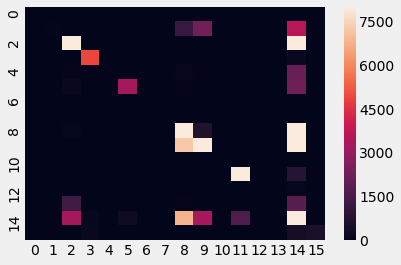

In [209]:
import seaborn as sns
sns.heatmap(cm,vmax=8000)

## Try to figure out why predictions are wrong

In [192]:
# create comparison dataframe
foo = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
bar = pd.concat([foo,X_test],axis=1)
bar = bar.merge(df[power_cols],left_index=True,right_index=True,how='left')

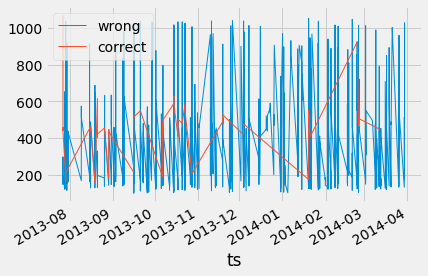

In [179]:
lbl = 'washer'
mask = (y_test==4)&(y_pred==18)
bar[lbl][mask].plot(linewidth=1,label='wrong',legend=True);
mask = (y_test==4)&(y_pred==4)
bar[lbl][mask].plot(linewidth=1,label='correct',legend=True);

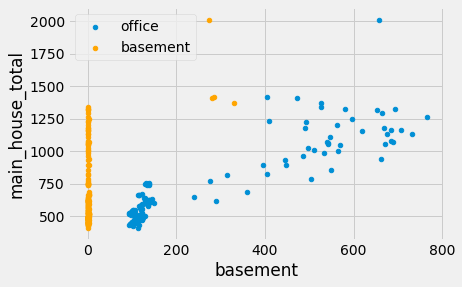

In [191]:
lbl1 = 'office'
lbl2 = 'basement'
xlbl = 'main_house_total'
mask = (y_test==14)&(y_pred!=14)
ax = bar[mask].plot(kind='scatter',x=lbl1,y=xlbl,linewidth=1,label=lbl1,legend=True);
bar[mask].plot(kind='scatter',x=lbl2,y=xlbl,linewidth=1,label=lbl2,legend=True,color='Orange',ax=ax);

## Predict Categorical Max

In [ ]:
remap = {'dishwasher':1,'dryer':1,'washer':1,'oven':1,
         'dhw_heater':3,'refrigerator':3,
         'furnace_fan':4,'heat_pump':4,
         'basement':2,'dining_room':2,'entertainment':2,'garage':2,'south_br':2,'north_br':2,'security_system':2,
        'utility_room':2,'workbench':2,'outside_plug':2,'unmetered':2,'office':2}

In [ ]:
df['col_max_row_categorized'] = df['col_max_row'].map(remap)

In [ ]:
feature_cols = feature_creation(df)
lbl = 'col_max_row_categorized'
model_type = 'random_forest'

X = df[feature_cols]
y = df[lbl]

X_train, X_test, y_train, y_test = tts(X,y)

model, y_pred, y_pred_proba = model_chooser(model_type,X_train,X_test,y_train,n_estimators=100,max_features='auto')

In [ ]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

In [ ]:
y_test.value_counts()

In [ ]:
from collections import Counter
Counter(y_pred)

In [ ]:
# total accuracy
most_common_val = y_test.value_counts(sort=True).head(1).index[0]
y_null = np.ones(len(y_test))*most_common_val
print('Null Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_null)))
print('Total Accuracy Score: {:0.4f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Log Loss: {:0.4f}'.format(metrics.log_loss(y_test,y_pred_proba)))
print(metrics.classification_report(y_test, y_pred))
print(metrics.confusion_matrix(y_test,y_pred))


In [ ]:
pd.DataFrame(list(zip(feature_cols,model.feature_importances_))).sort_values(by=1,ascending=False)

## Try to figure out why predictions are wrong

In [ ]:
foo = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
bar = pd.concat([foo,X_test],axis=1)
bar[bar.y_test!=bar.y_pred]

## Attempt to use Pipeline

In [ ]:
feature_cols = feature_creation(df)
lbl = 'col_max_row_categorized'

X = df[feature_cols]
y = df[lbl]

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
# potentially useful
# http://www.codiply.com/blog/hyperparameter-grid-search-across-multiple-models-in-scikit-learn/
# https://stackoverflow.com/questions/46732748/how-do-i-use-a-timeseriessplit-with-a-gridsearchcv-object-to-tune-a-model-in-sci

In [ ]:
# create a pipeline
pipe = make_pipeline(RandomForestClassifier(random_state=42))

# search for an optimal hyperparameters
ne = list(range(30,150,30))
mf = list(range(1,X.shape[1]-1,5))

# train test split time series
tscv = TimeSeriesSplit(n_splits=2).split(X)

# create a param grid
param_grid = dict(randomforestclassifier__n_estimators=ne
                 , randomforestclassifier__max_features = mf)

# create a grid search
rs = RandomizedSearchCV(pipe, param_grid, cv=tscv, scoring='accuracy', n_iter = 10, n_jobs=-1,)

# fit the grid
rs.fit(X, y)

# view the best_score_ and best_params_
print(rs.best_score_)
print(rs.best_params_)